# **Spin** calculation

IDEA:
- take in consideration only the ball for each frame
- draw a lot of points on the ball
- take the motion of these points between consecutive frames (optical flow)
- from this motion we extract the direction of the rotation and so the axis of rotation

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from pathlib import Path
from IPython.display import clear_output, display

In [2]:
VIDEO_NUMBER = "2"
PROJECT_ROOT = Path().resolve().parent.parent
INPUT_VIDEO_PATH = str(PROJECT_ROOT / "data" / f"recording_{VIDEO_NUMBER}" / f"Recording_{VIDEO_NUMBER}.mp4")
INPUT_CSV_PATH = str(PROJECT_ROOT / "data" / "auxiliary_data" / "circle_positions" / f"Adjusted_positions_new_{VIDEO_NUMBER}.csv")

In [3]:
cap = cv2.VideoCapture(INPUT_VIDEO_PATH)
if not cap.isOpened():
    raise IOError("Error: Could not open video.")
df = pd.read_csv(INPUT_CSV_PATH)
if df.empty:
    raise ValueError("Error: The CSV file is empty.")

fps = cap.get(cv2.CAP_PROP_FPS)
frame_idx = 0

# Read first frame
ret, prev_frame = cap.read()
if not ret:
    print("Cannot read first frame.")

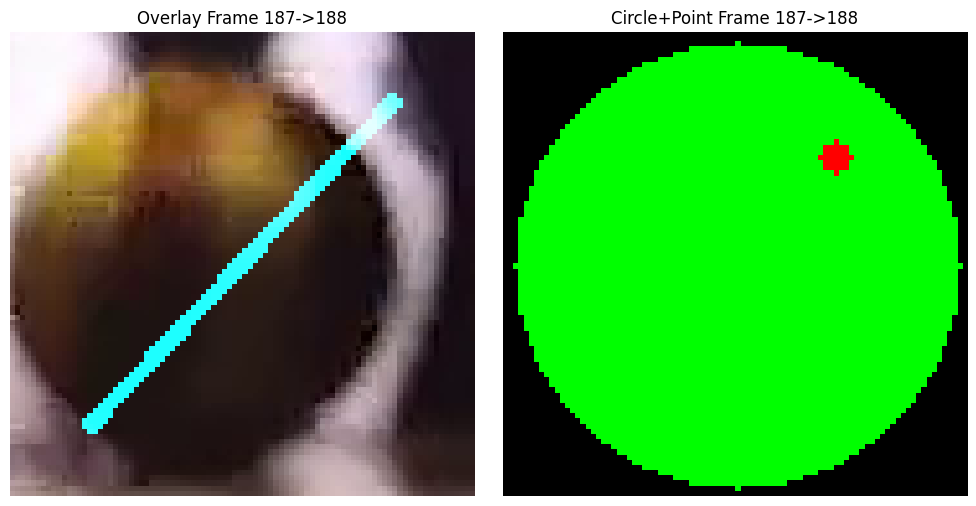

<Figure size 640x480 with 0 Axes>

End of video or cannot read frame.
Done.


In [4]:
while True:
    # Read next frame
    ret, curr_frame = cap.read()
    if not ret:
        print("End of video or cannot read frame.")
        break

    # Retrieve detection for this frame_idx
    if frame_idx >= len(df):
        print(f"No CSV entry for frame {frame_idx}, skipping.")
        prev_frame = curr_frame
        frame_idx += 1
        continue
    row = df.iloc[frame_idx]
    if pd.isna(row['x']) or pd.isna(row['y']) or pd.isna(row['radius']):
        #print(f"Missing detection at frame {frame_idx}, skipping.")
        prev_frame = curr_frame
        frame_idx += 1
        continue

    # Ball parameters
    ball_center = np.array([int(row['x']), int(row['y'])])
    ball_radius = int(row['radius'])

    # Define ROI bounds
    offset = 2
    x_min = max(ball_center[0] - ball_radius - offset, 0)
    x_max = min(ball_center[0] + ball_radius + offset, prev_frame.shape[1])
    y_min = max(ball_center[1] - ball_radius - offset, 0)
    y_max = min(ball_center[1] + ball_radius + offset, prev_frame.shape[0])

    # Crop
    roi1 = prev_frame[y_min:y_max, x_min:x_max]
    roi2 = curr_frame[y_min:y_max, x_min:x_max]
    gray1 = cv2.cvtColor(roi1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(roi2, cv2.COLOR_BGR2GRAY)

    # Center in ROI
    center_roi = np.array([ball_center[0] - x_min, ball_center[1] - y_min])

    # Sample points inside circle
    h, w = gray1.shape
    pts = []
    while len(pts) < 500:
        x, y = np.random.randint(0, w), np.random.randint(0, h)
        if (x - center_roi[0])**2 + (y - center_roi[1])**2 <= (ball_radius-5)**2:
            pts.append([x, y])
    p0 = np.array(pts, dtype=np.float32).reshape(-1,1,2)

    # Optical flow
    p1, status, _ = cv2.calcOpticalFlowPyrLK(
        gray1, gray2, p0, None,
        winSize=(15,15), maxLevel=2,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
    )

    # Lift to 3D
    old3d, new3d = [], []
    for o, n, s in zip(p0.reshape(-1,2), p1.reshape(-1,2), status.reshape(-1)):
        if s == 1:
            ox, oy = o - center_roi
            nx, ny = n - center_roi
            oz = np.sqrt(max(ball_radius**2 - ox**2 - oy**2, 0))
            nz = np.sqrt(max(ball_radius**2 - nx**2 - ny**2, 0))
            old3d.append([ox, oy, oz])
            new3d.append([nx, ny, nz])
    old3d, new3d = np.array(old3d), np.array(new3d)

    if len(old3d) < 3:
        print(f"Insufficient points at frame {frame_idx}, skipping axis.")
        prev_frame = curr_frame
        frame_idx += 1
        continue

    # Kabsch algorithm for rotation
    H = old3d.T @ new3d
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1,:] *= -1
        R = Vt.T @ U.T
    theta = np.arccos((np.trace(R) - 1) / 2)
    axis = np.array([R[2,1] - R[1,2], R[0,2] - R[2,0], R[1,0] - R[0,1]])
    axis = axis / (2 * np.sin(theta))
    axis = axis / np.linalg.norm(axis)

    # Visualization mask on ROI
    mask = np.zeros_like(roi2)
    # Project equator line
    if axis[2] != 0:
        equator_dir = axis[:2] / np.linalg.norm(axis[:2])
        pA = (center_roi + equator_dir * ball_radius).astype(int)
        pB = (center_roi - equator_dir * ball_radius).astype(int)
        cv2.line(mask, tuple(pA), tuple(pB), (255,255,0), 2)

        rotation_pt = (-axis * ball_radius)[:2] + center_roi
        rot_pt_int = tuple(rotation_pt.astype(int))
        #cv2.circle(mask, rot_pt_int, 4, (0,255,0), -1)

    # Overlay on ROI2
    overlay = cv2.addWeighted(roi2, 1, mask, 1, 0)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    # Create blank circle image with point
    circle_img = np.zeros_like(roi2)
    # Draw circle outline
    cv2.circle(circle_img, tuple(center_roi.astype(int)), ball_radius, (0,255,0), -1)
    # Draw detected rotation point
    cv2.circle(circle_img, rot_pt_int, 3, (0,0,255), -1)
    circle_rgb = cv2.cvtColor(circle_img, cv2.COLOR_BGR2RGB)

    # Display side by side
    clear_output(wait=True)
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    for ax, img, title in zip(axs, [overlay_rgb, circle_rgb], ['Overlay', 'Circle+Point']):
        ax.imshow(img)
        ax.set_title(f'{title} Frame {frame_idx}->{frame_idx+1}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    display(plt.gcf())
    plt.close()
    time.sleep(1/fps)

    prev_frame = curr_frame
    frame_idx += 1

cap.release()
print("Done.")
